# Snow Cover Fraction (scf)
conda env: new `phd_v3` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar

import sys
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 31 GB / available: 17 GB / percent used: 42.5 %


In [18]:
# Define period
period = slice('1981','2014')
period_2 = slice('2001','2012')

# Define zone
latlim=slice(10,50)
lonlim=slice(60,110)

root_data_path = '/home/lalandmi/Dropbox/data/' # local
# root_data_path = '/data/mlalande/' # CICLAD

## Load elevation file

In [3]:
path = '/home/lalandmi/Dropbox/data/GMTED2010/'
ds = xr.open_dataset(path+'GMTED2010_15n120_0500deg.nc') \
    .drop_dims('nbounds') \
    .swap_dims({'nlat': 'latitude', 'nlon': 'longitude'}) \
    .drop({'nlat', 'nlon'}) \
    .rename({'latitude': 'lat', 'longitude': 'lon'}) \
    .sel(lat=latlim, lon=lonlim)

elevation = ds.elevation
elevation_std = ds.elevation_stddev

## NOAA CDR

https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00756

In [5]:
ds_rutger = xr.open_dataset(root_data_path+'NOAA_CDR_NH_SCE/nhsce_v01r01_19661004_20201005.nc').sel(time=period)
with xr.set_options(keep_attrs=True): # Get the snc variable, keep only land data and convert to %
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100   
obs.attrs['units'] = '%'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
noaa_cdr = regridder(obs)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Create weight file: bilinear_88x88_80x100.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


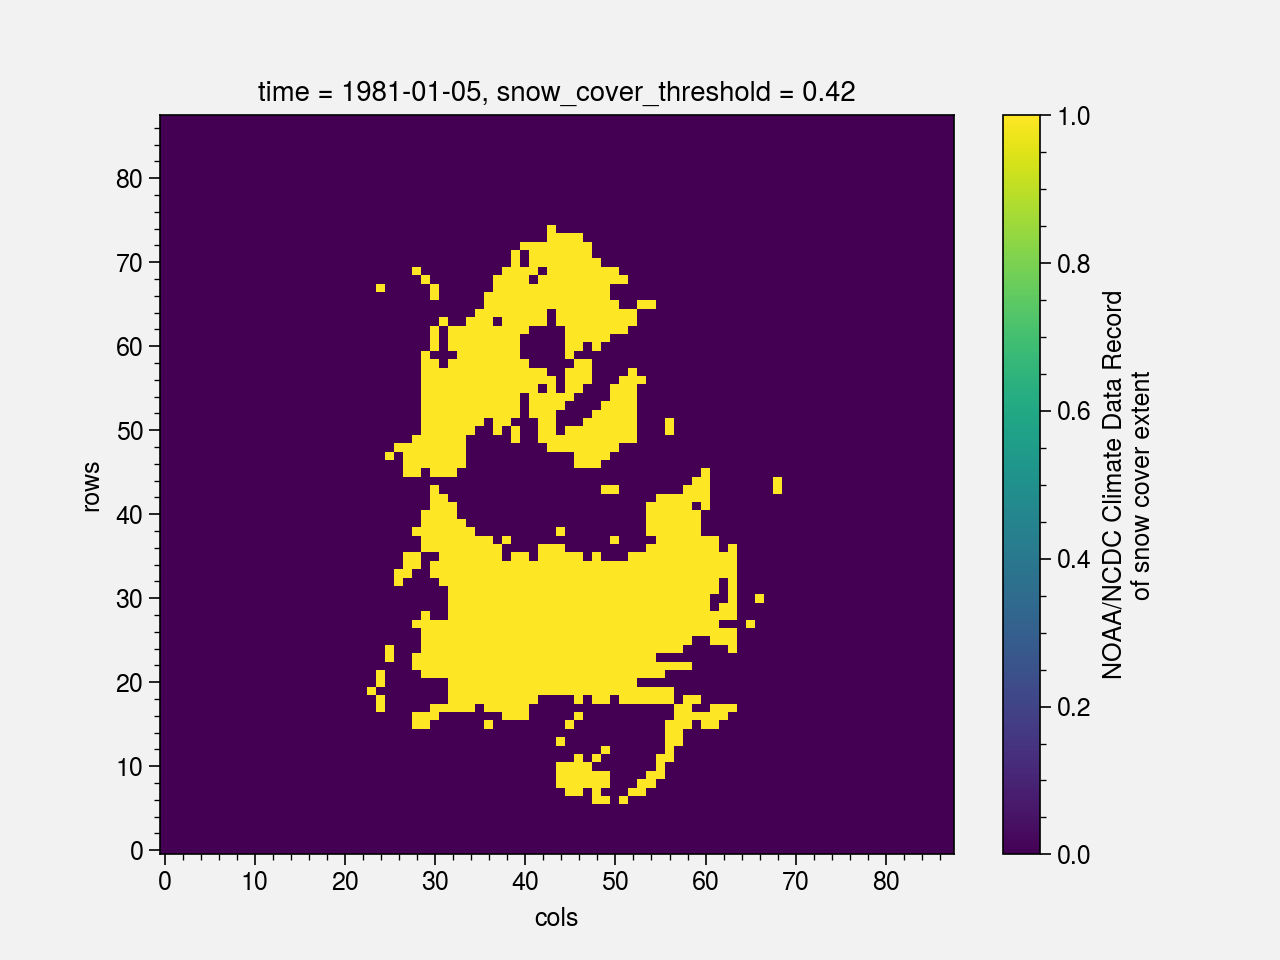

In [14]:
ds_rutger.snow_cover_extent[0].plot()

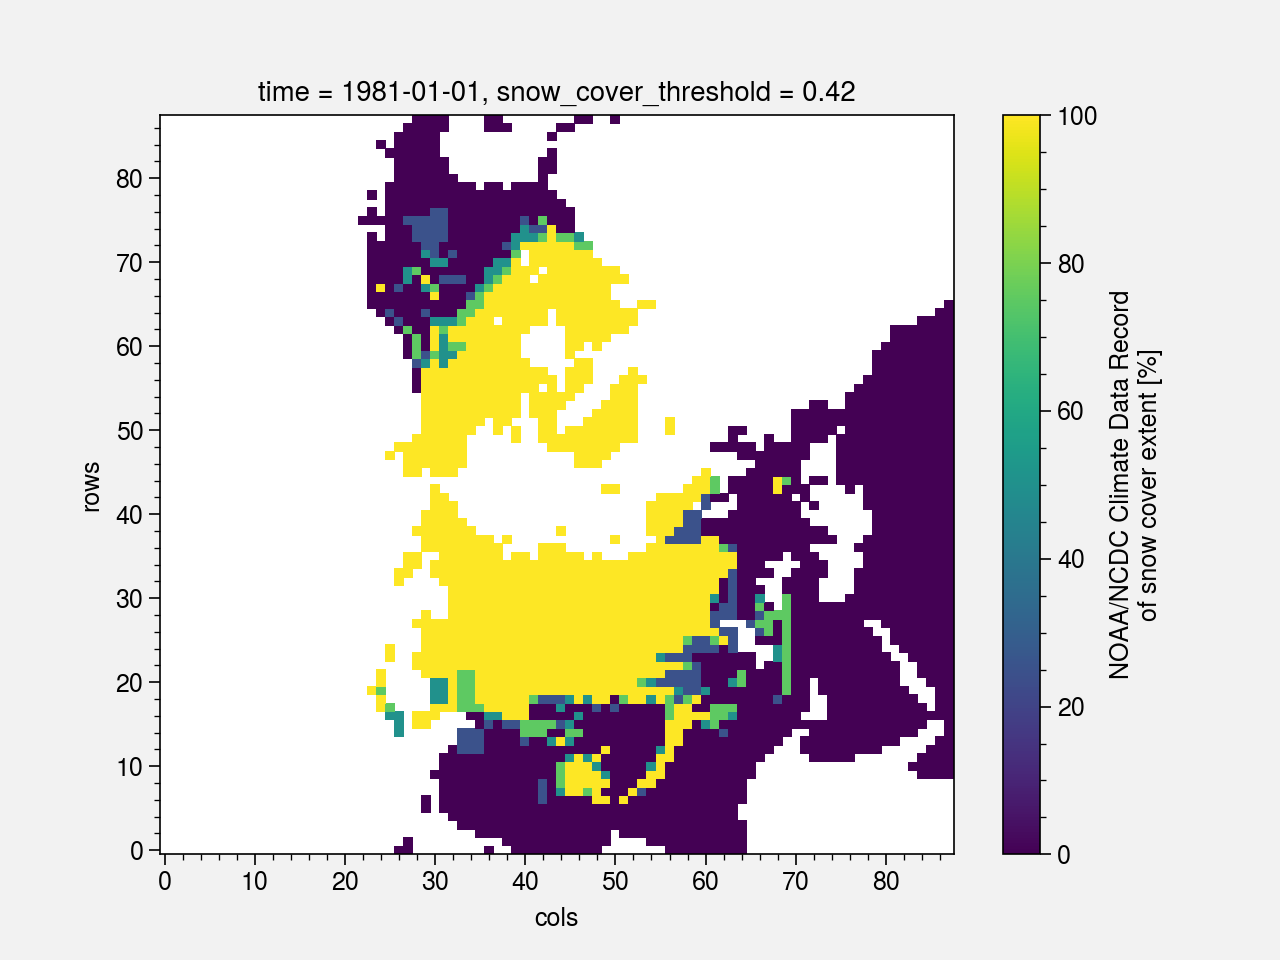

In [10]:
obs[0].plot()

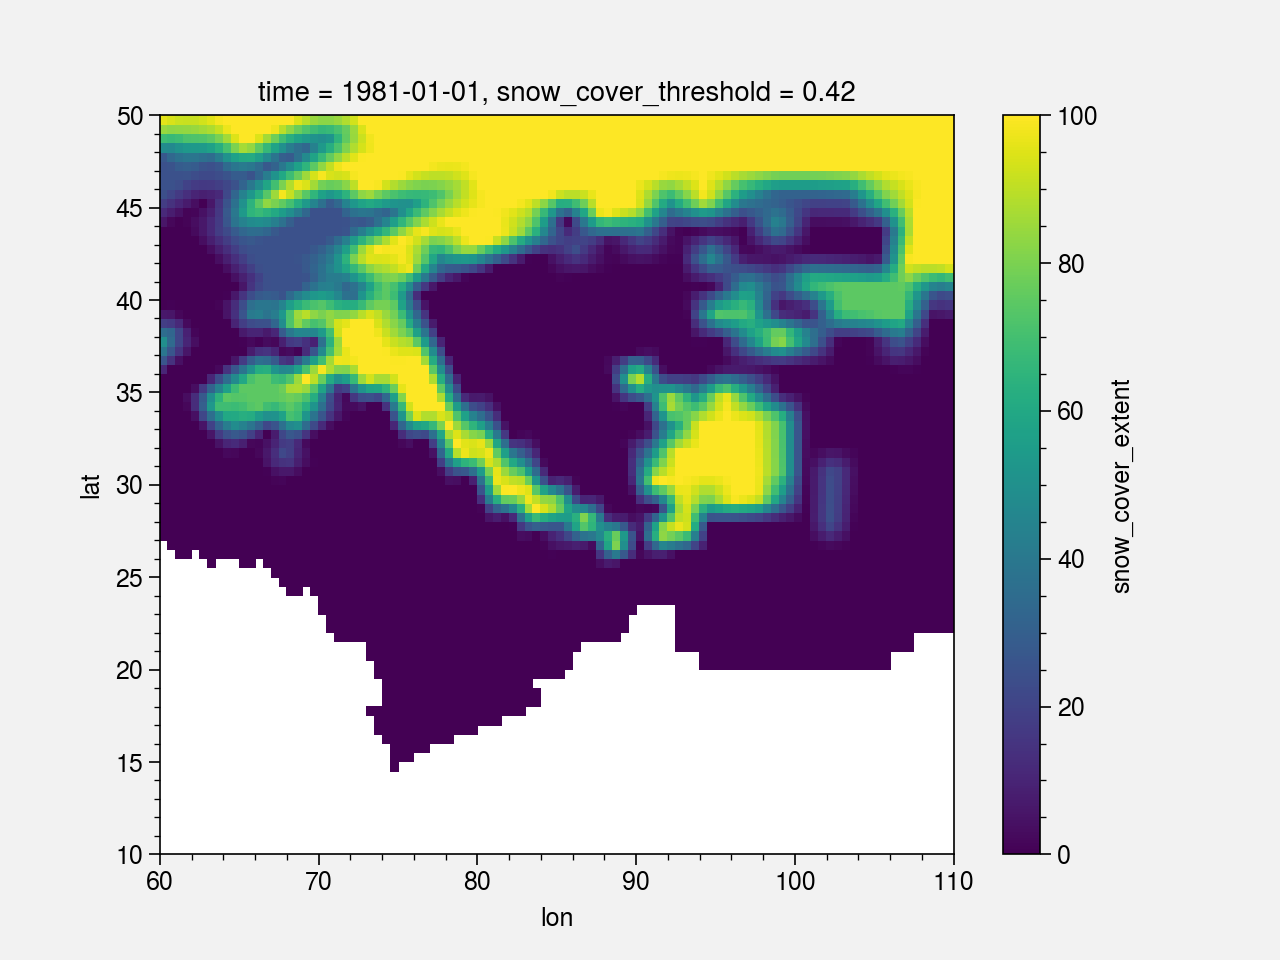

In [7]:
noaa_cdr[0].plot()

In [62]:
noaa_cdr_mon = noaa_cdr.groupby('time.month').mean()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


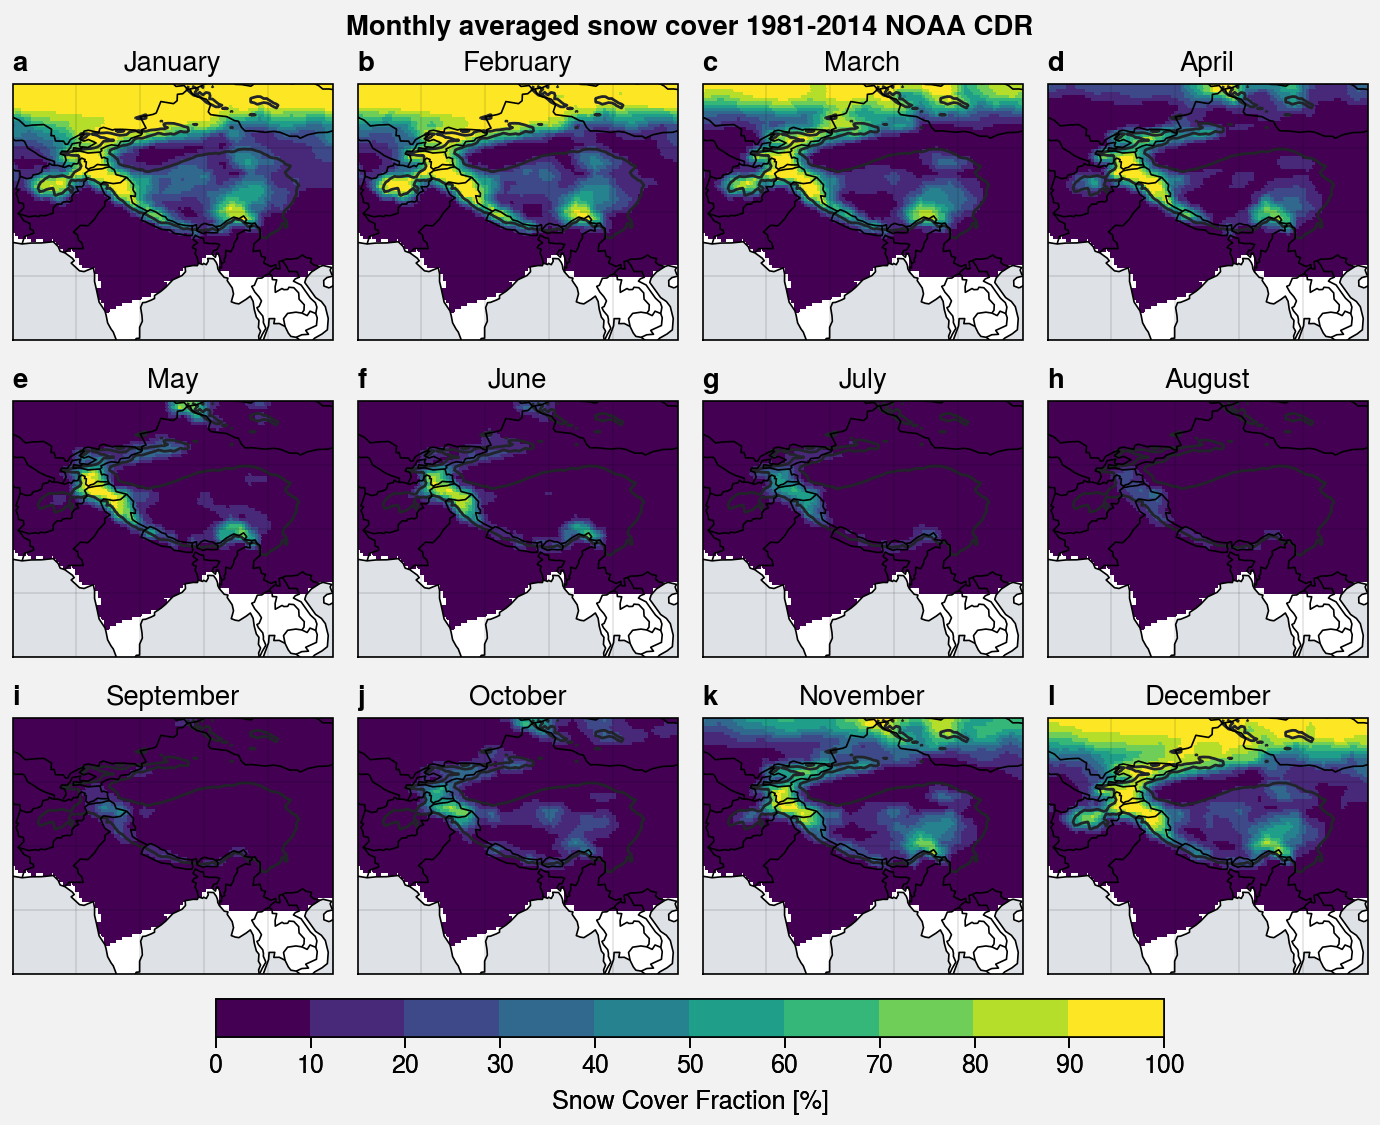

In [67]:
cmap='viridis'
levels=plot.arange(0,100,10)

# Define zone
latlim=slice(10,50)
lonlim=slice(60,110)

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3, share=3, axwidth=1.6)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        noaa_cdr_mon.isel(month=i), 
        cmap=cmap,  
        levels=levels,
        extend='neither'
    )
    ax.format(title=calendar.month_name[i+1])
    
for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)
    
f.colorbar(m, label='Snow Cover Fraction [%]', loc='b', length=0.7)

axs.format(
    labels=False, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='Monthly averaged snow cover 1981-2014 NOAA CDR',
    lonlines=10, latlines=10, abc=True, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

for ext in ['jpg', 'pdf']:
    f.save('img/noaa_cdr_mon_1981-2014.'+ext)

# Comparison

In [102]:
u.get_domain_HMA()

(slice(20, 45, None), slice(60, 110, None))

In [194]:
latlim, lonlim = u.get_domain_HMA()

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

In [195]:
noaa_cdr_2 = noaa_cdr.sel(time=period_2, lat=latlim, lon=lonlim)

## ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

In [196]:
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/*.nc', parallel=True).sel(time=period_2, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_interp_orig = ds.scfg_interp

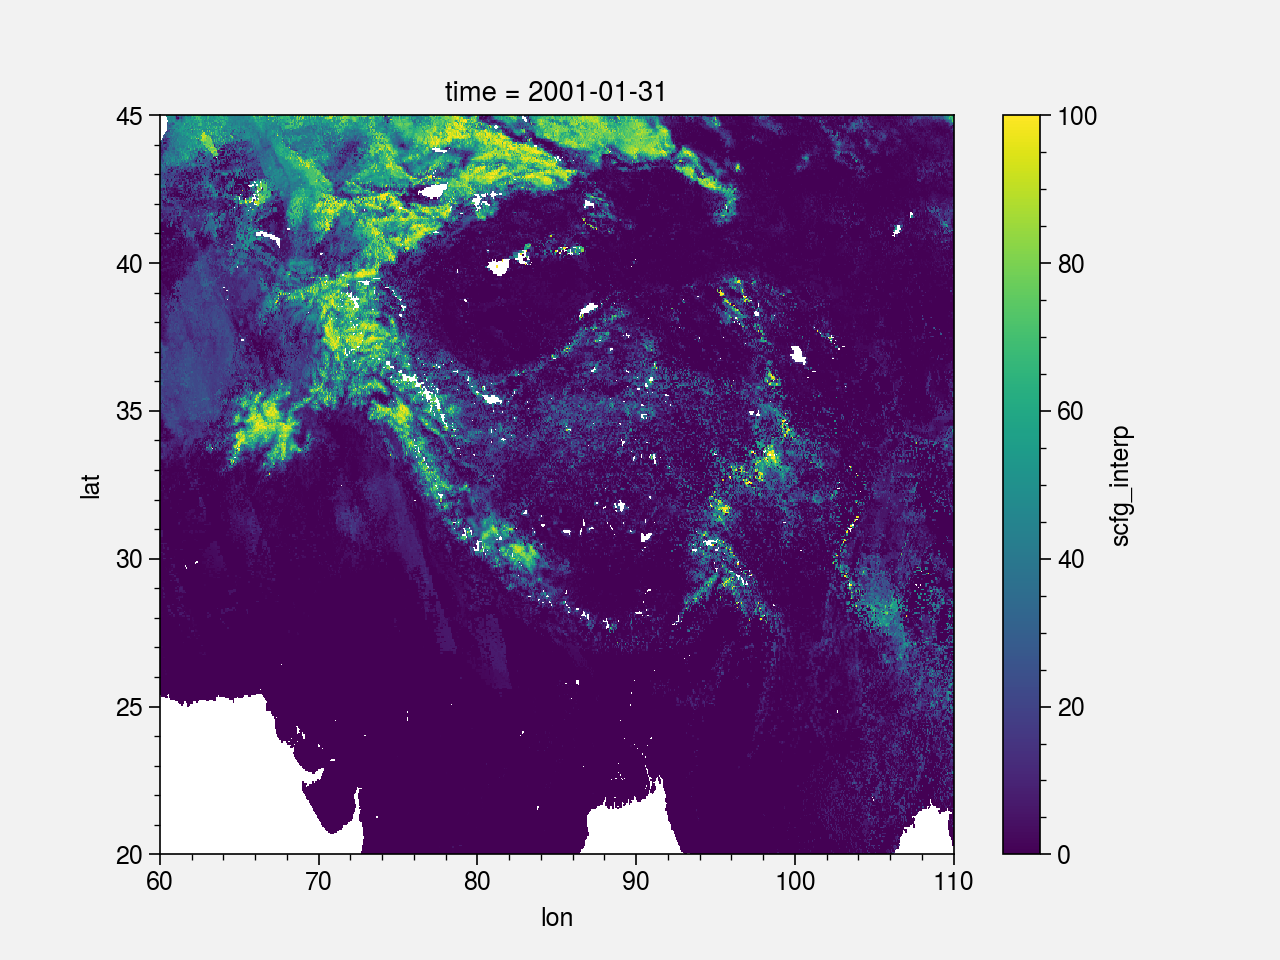

In [197]:
snow_cci_interp_orig[0].plot()

In [198]:
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_0.5deg/*.nc', parallel=True).sel(time=period_2, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_interp = ds['scfg_interp_0.5deg_icefilled']
snow_cci_interp['time'] = noaa_cdr_2.time

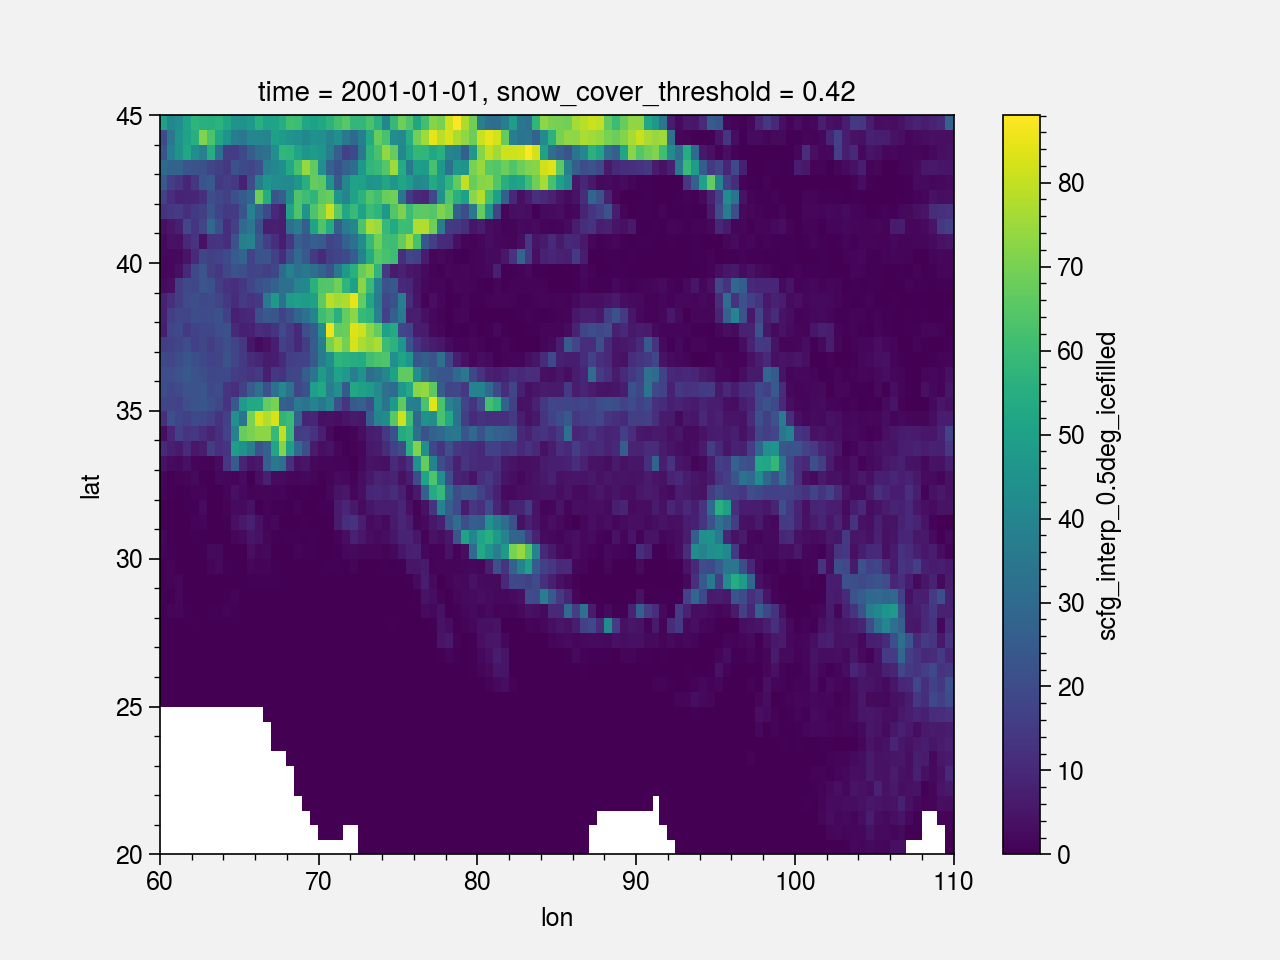

In [199]:
snow_cci_interp[0].plot()

## ESA snow CCI MODIS (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_MODIS_gricad_v1.ipynb

In [200]:
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly/*.nc', parallel=True).sel(time=period_2, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_MODIS_interp_orig = ds.scfg_interp

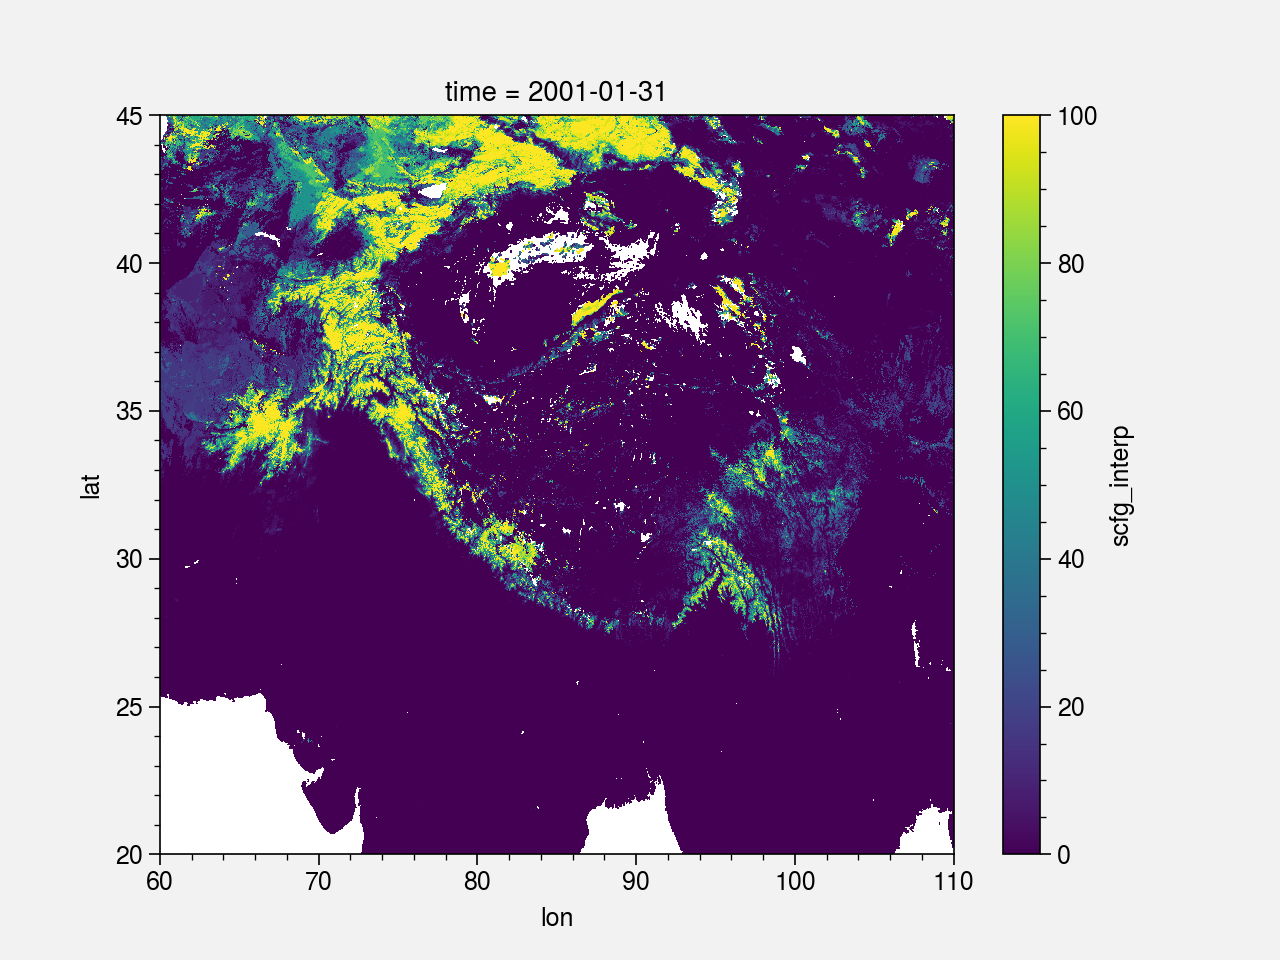

In [201]:
snow_cci_MODIS_interp_orig[0].plot()

In [226]:
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/MODIS/v2.0/monthly_0.5deg/*.nc', parallel=True).sel(time=period_2, lat=latlim, lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_MODIS_interp = ds['scfg_interp_0.5deg_icefilled']
snow_cci_MODIS_interp['time'] = noaa_cdr_2.time
snow_cci_MODIS_interp['lat'] = snow_cci_interp.lat
snow_cci_MODIS_interp['lon'] = snow_cci_interp.lon

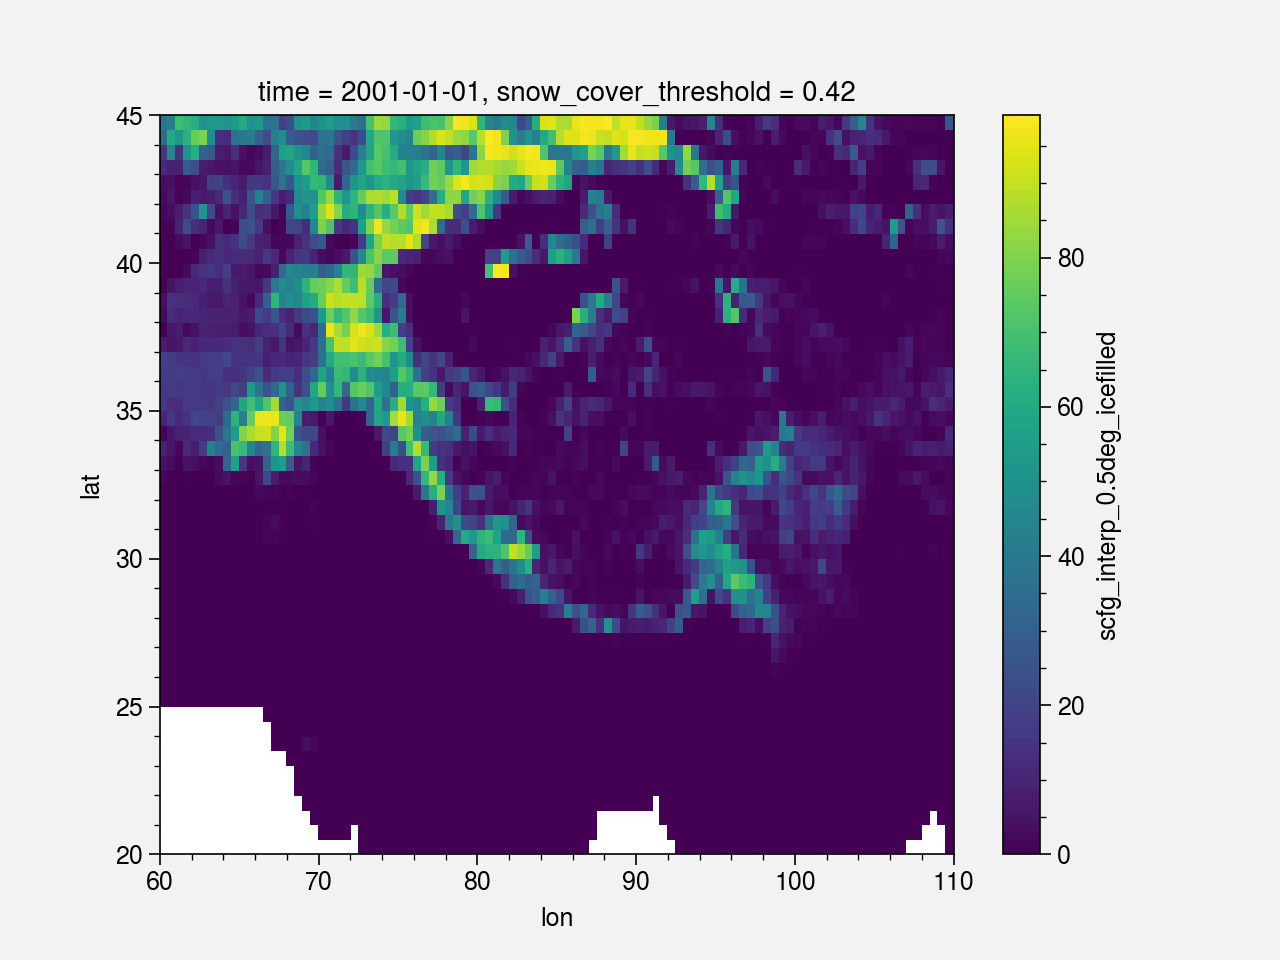

In [227]:
snow_cci_MODIS_interp[0].plot()

## ESA snow CCI AVHRR (3 days gapfill)

chekc la version old aussi pour être sur (version pas old mauvaise)

In [235]:
ds = xr.open_dataset(root_data_path+'/esacci/ESA_CCI_snow_SCFG_v1.0_HKH_gapfilled_monthly_old/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_montlhy_1982-2014.nc').sel(time=period_2, lat=slice(latlim.stop, latlim.start), lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_avhrr_3d_not_filled_old = ds.snc

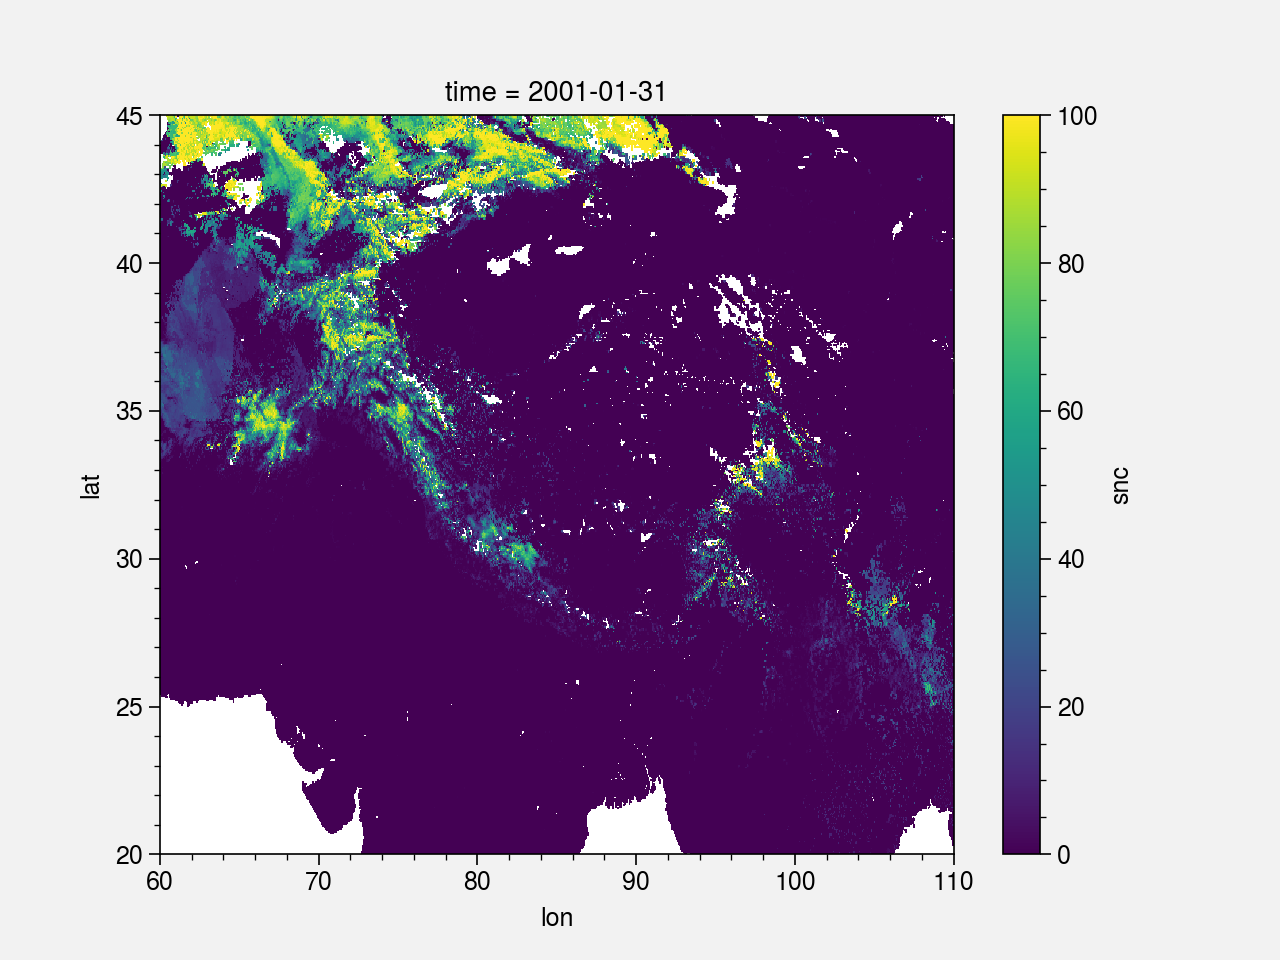

In [236]:
snow_cci_avhrr_3d_not_filled_old[0].plot()

In [237]:
ds = xr.open_dataset(root_data_path+'/esacci/ESA_CCI_snow_SCFG_v1.0_HKH_gapfilled_monthly_old/ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv1.0_HKH_gapfilled_icefilled_montlhy_1982-2014.nc').sel(time=period_2, lat=slice(latlim.stop, latlim.start), lon=lonlim)
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)

snow_cci_avhrr_3d = ds.snc

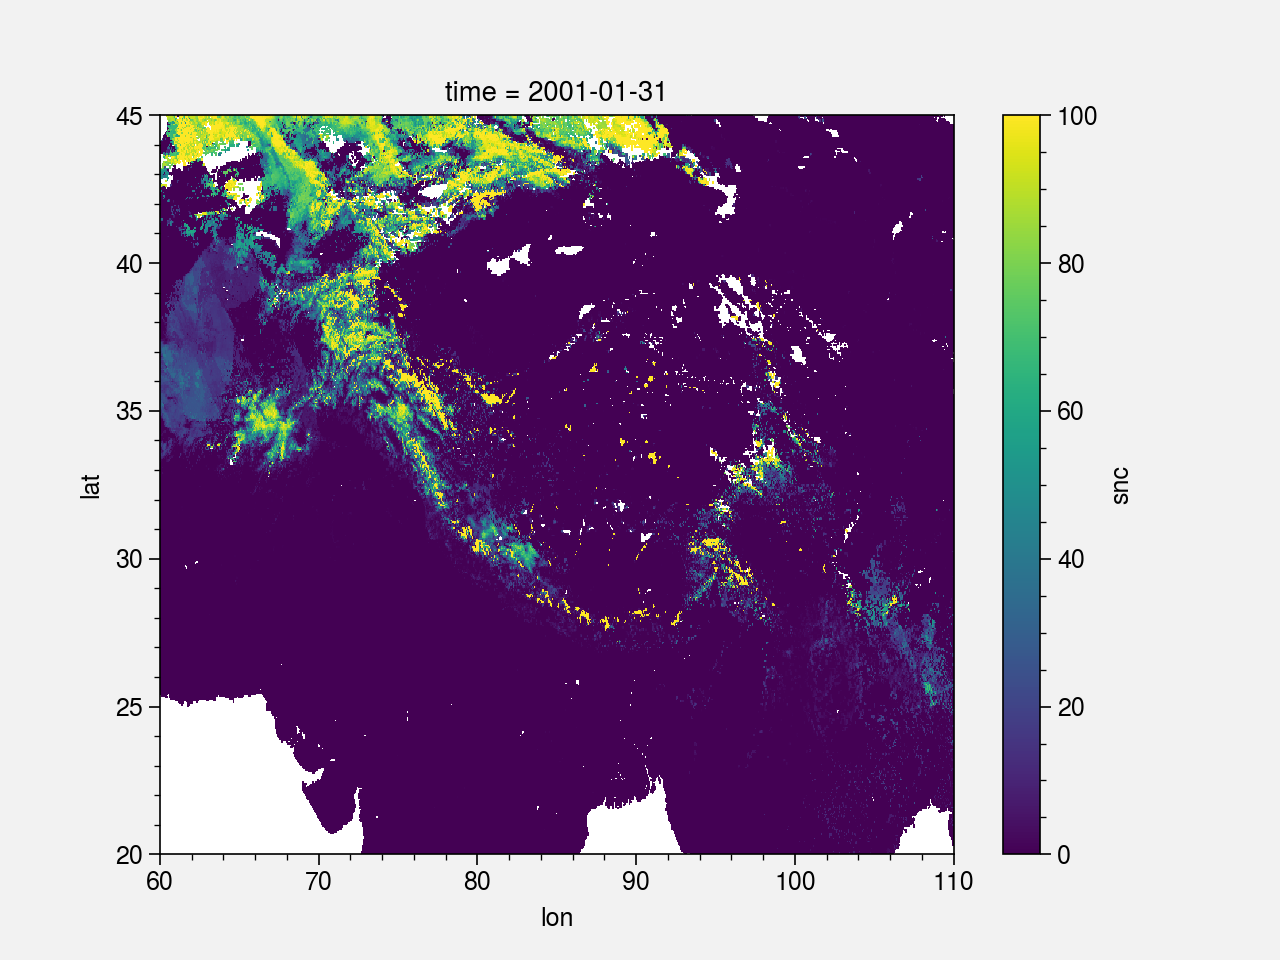

In [238]:
snow_cci_avhrr_3d[0].plot()

In [259]:
snow_cci_avhrr_3d_coarsen = snow_cci_avhrr_3d.coarsen(lat=10, lon=10).mean()
snow_cci_avhrr_3d_coarsen['time'] = noaa_cdr_2.time
snow_cci_avhrr_3d_coarsen['lat'] = snow_cci_interp.lat[::-1]
snow_cci_avhrr_3d_coarsen['lon'] = snow_cci_interp.lon

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


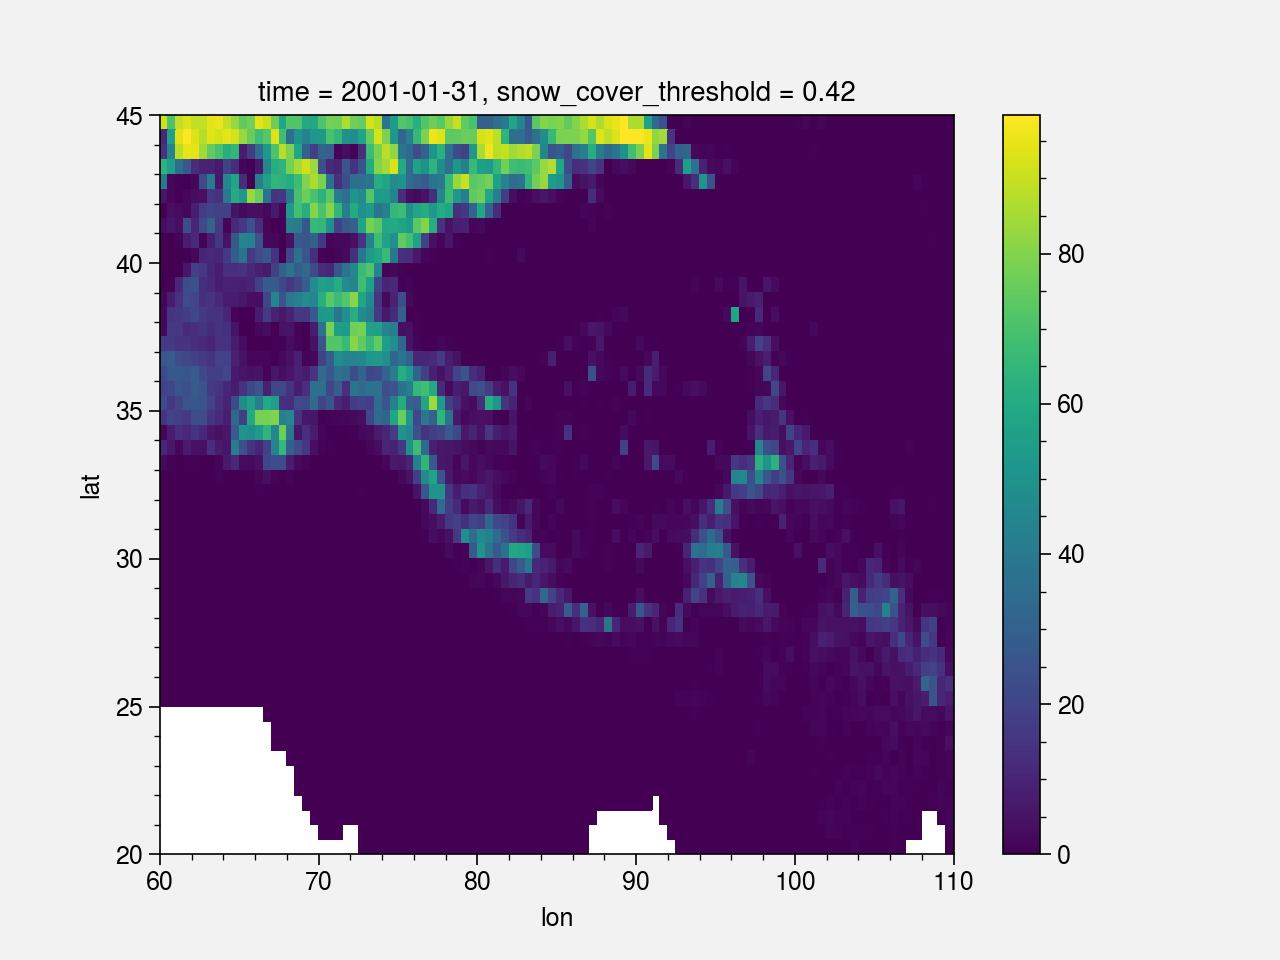

In [254]:
snow_cci_avhrr_3d_coarsen[0].plot()

## MODIS/Terra Snow Cover Monthly L3 Global 0.05Deg CMG, Version 6

https://nsidc.org/data/MOD10CM

In [86]:
snow_cci_interp

<xarray.DataArray 'scfg_interp_0.5deg_icefilled' (time: 144, lat: 80, lon: 100)>
dask.array<getitem, shape=(144, 80, 100), dtype=float64, chunksize=(12, 80, 100), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 10.25 10.75 11.25 11.75 ... 48.25 48.75 49.25 49.75
  * lon      (lon) float64 60.25 60.75 61.25 61.75 ... 108.2 108.8 109.2 109.8
  * time     (time) datetime64[ns] 2001-01-31 2001-02-28 ... 2012-12-31

In [261]:
ds = xr.open_mfdataset(root_data_path+'/MODIS/MOD10CM/netcdf/*.nc').sel(time=period_2, lat=slice(latlim.stop, latlim.start), lon=lonlim)
# Check if the time steps are ok
# np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, ds.time.size)
# Missing few months

modis = ds.Snow_Cover_Monthly_CMG
modis = modis.where(modis <= 100)

In [262]:
modis

<xarray.DataArray 'Snow_Cover_Monthly_CMG' (time: 141, lat: 500, lon: 1000)>
dask.array<where, shape=(141, 500, 1000), dtype=float32, chunksize=(1, 500, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 44.97 44.92 44.87 44.82 ... 20.17 20.12 20.07 20.02
  * lon      (lon) float64 60.03 60.08 60.13 60.18 ... 109.8 109.9 109.9 110.0
  * time     (time) datetime64[ns] 2001-01-16 2001-02-14 ... 2012-12-16
Attributes:
    long_name:             Monthly snow cover extent, 5km
    units:                 none
    format:                I3
    coordsys:              latitude, longitude
    valid_range:           [  0 100]
    Mask_value:            254
    Night_value:           211
    Cell_resolution:       0.05 deg
    Antarctica_snow_note:  Antarctica deliberately mapped as snow
    Key:                   0-100=percent of snow in cell, 211=night, 250=clou...

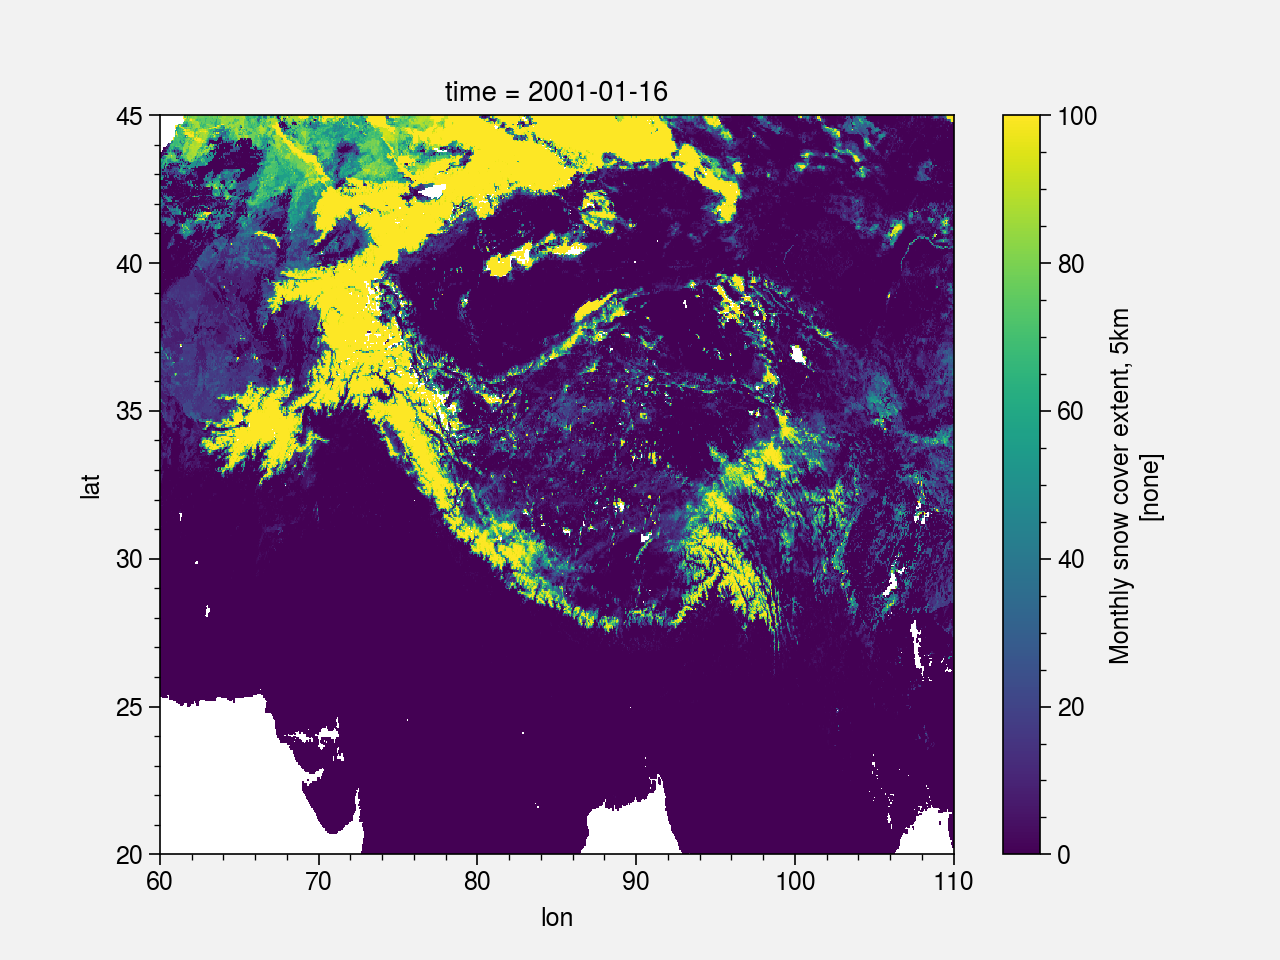

In [263]:
modis[0].plot()

In [275]:
modis_coarsen = modis.coarsen(lat=10, lon=10).mean()
# modis_coarsen['time'] = noaa_cdr_2.time
modis_coarsen['lat'] = snow_cci_interp.lat[::-1]
modis_coarsen['lon'] = snow_cci_interp.lon

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


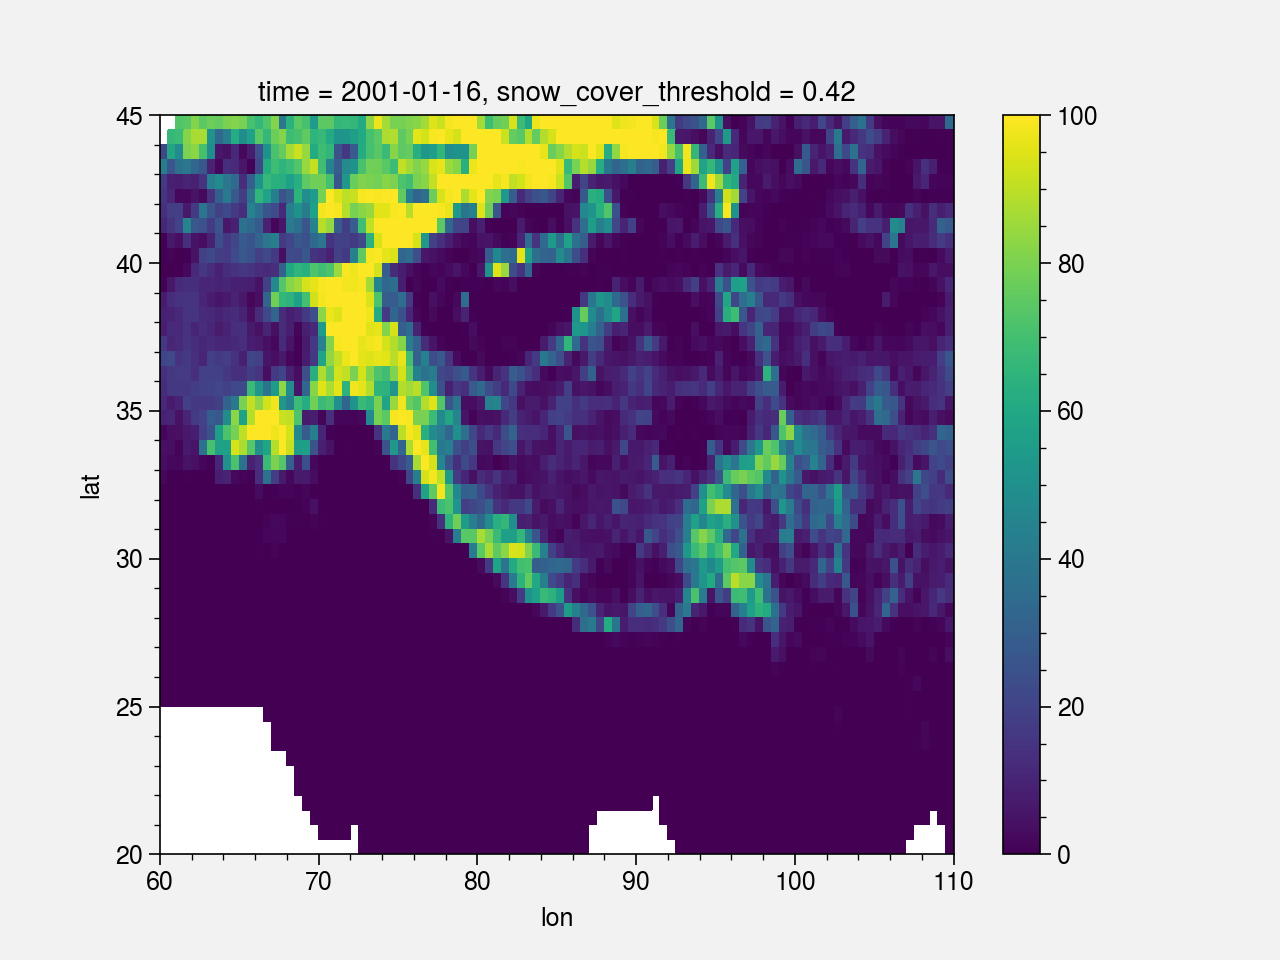

In [276]:
modis_coarsen[0].plot()

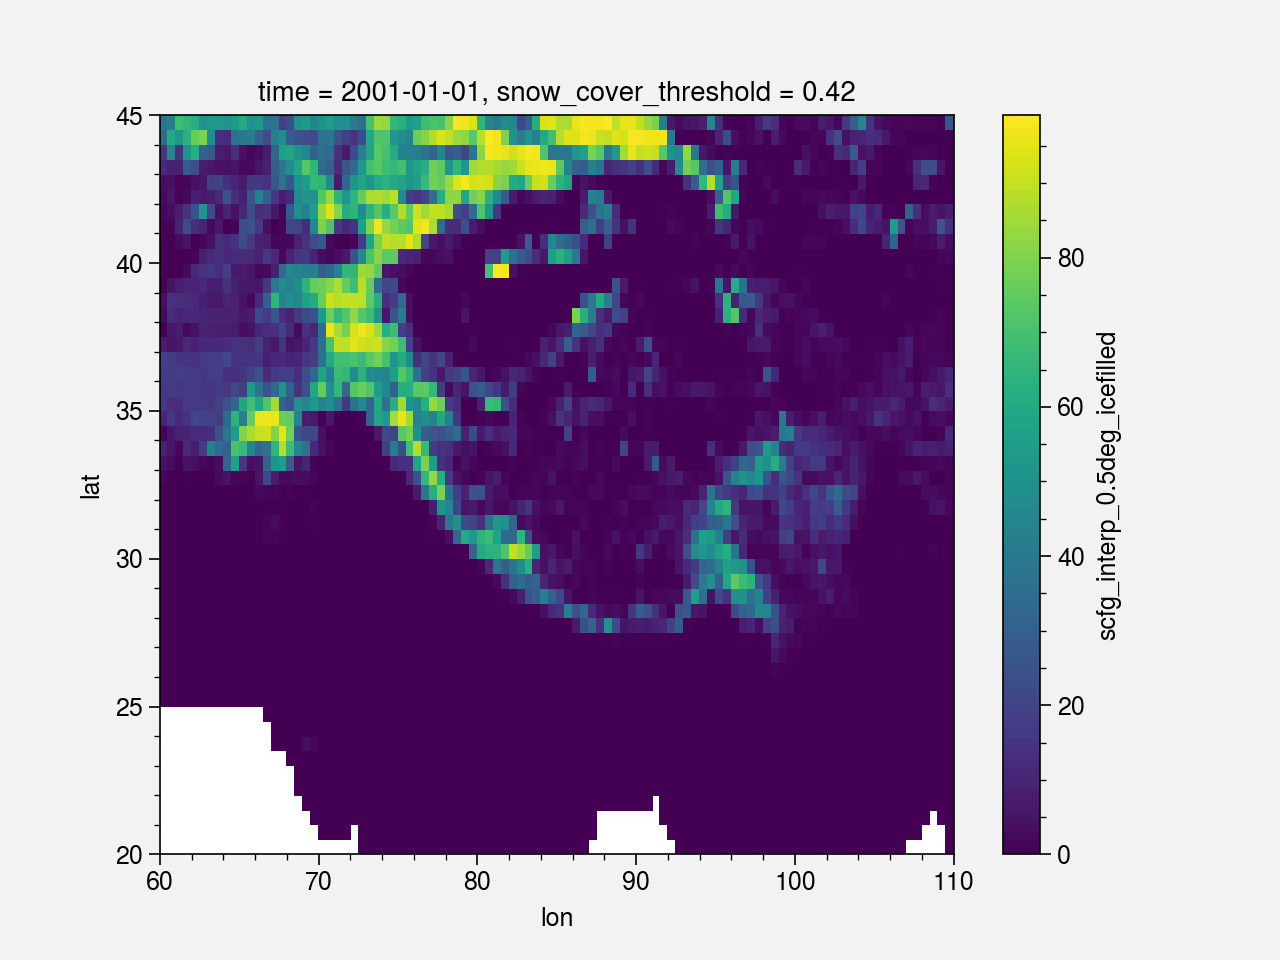

In [266]:
snow_cci_MODIS_interp[0].plot()

## MEaSUREs
https://nsidc.org/data/nsidc-0530

In [298]:
obs = xr.open_mfdataset(
    root_data_path+'MEaSUREs/monthly/nhtsd25e2_*_v01r01.nc', combine='by_coords'
).merged_snow_cover_extent.sel(time=period_2).load() * 100
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

In [299]:
# Check if the time steps are ok
np.testing.assert_equal((int(period_2.stop) - int(period_2.start) + 1)*12, obs.time.size)

# Because obs are not global (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder

regridder = xe.Regridder(obs, elevation, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
measures = regridder(obs)
measures = measures.sel(lat=latlim, lon=lonlim)

Reuse existing file: bilinear_720x720_80x100.nc


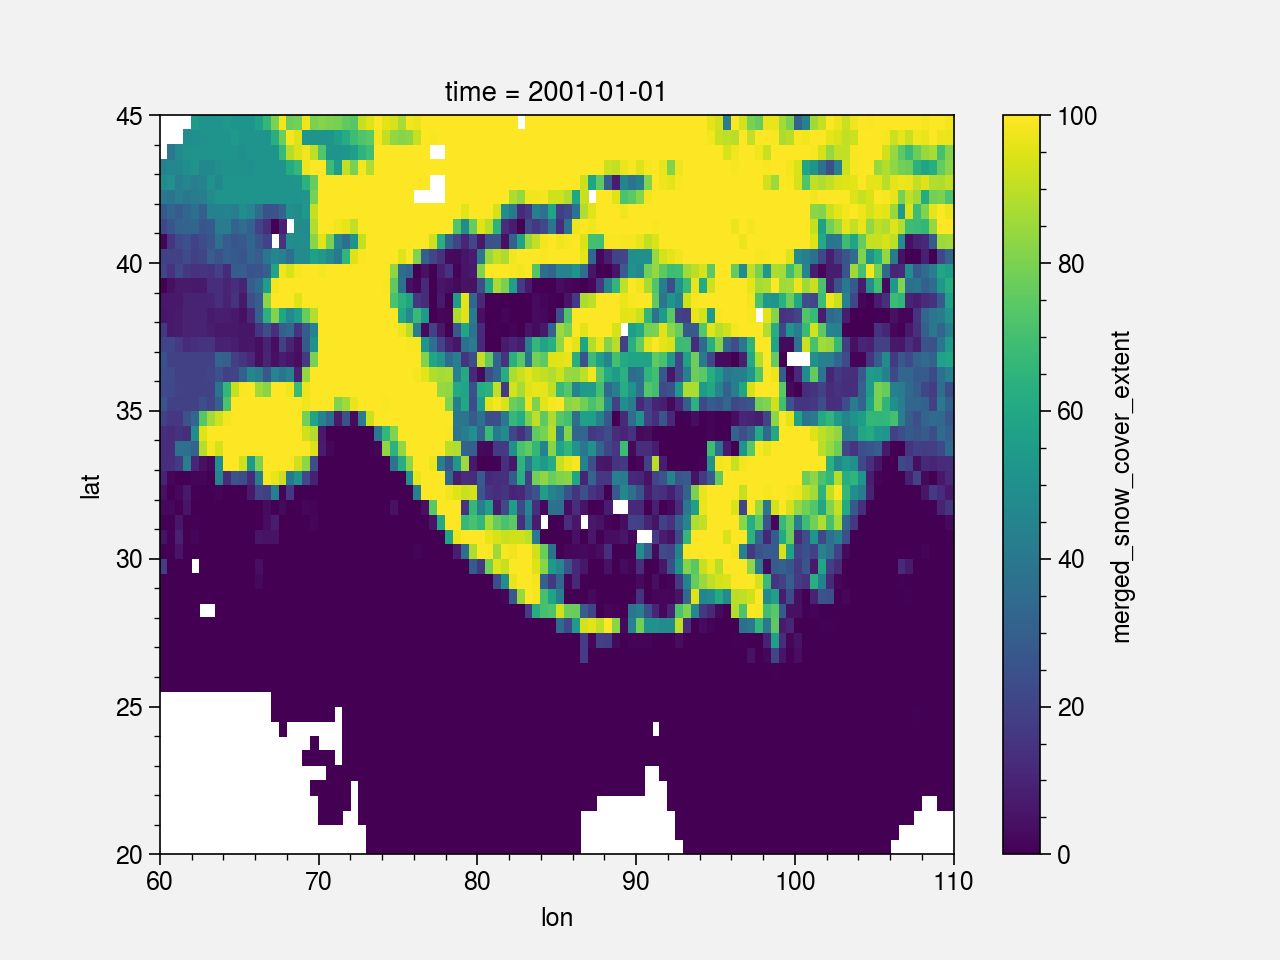

In [300]:
measures[0].plot()

## Plot

In [303]:
noaa_cdr_seas = noaa_cdr.groupby('time.season').mean('time').load()

snow_cci_interp_orig_seas = snow_cci_interp_orig.groupby('time.season').mean('time').load()
snow_cci_interp_seas = snow_cci_interp.groupby('time.season').mean('time').load()

snow_cci_MODIS_interp_orig_seas = snow_cci_MODIS_interp_orig.groupby('time.season').mean('time').load()
snow_cci_MODIS_interp_seas = snow_cci_MODIS_interp.groupby('time.season').mean('time').load()

# snow_cci_avhrr_3d_not_filled_old_seas = snow_cci_avhrr_3d_not_filled_old.groupby('time.season').mean('time').load()
# modis_seas = modis.groupby('time.season').mean('time').load()
measures_seas = measures.groupby('time.season').mean('time').load()

obs_list = [
    noaa_cdr_seas, snow_cci_interp_orig_seas, snow_cci_MODIS_interp_orig_seas, measures_seas,
    snow_cci_interp_seas - noaa_cdr_seas, snow_cci_MODIS_interp_seas - noaa_cdr_seas, measures_seas - noaa_cdr_seas
]

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142:

In [347]:
obs_list = [
    noaa_cdr_seas, snow_cci_interp_orig_seas, snow_cci_MODIS_interp_orig_seas, measures_seas,
    snow_cci_interp_seas - noaa_cdr_seas, snow_cci_MODIS_interp_seas - noaa_cdr_seas, measures_seas - noaa_cdr_seas
]

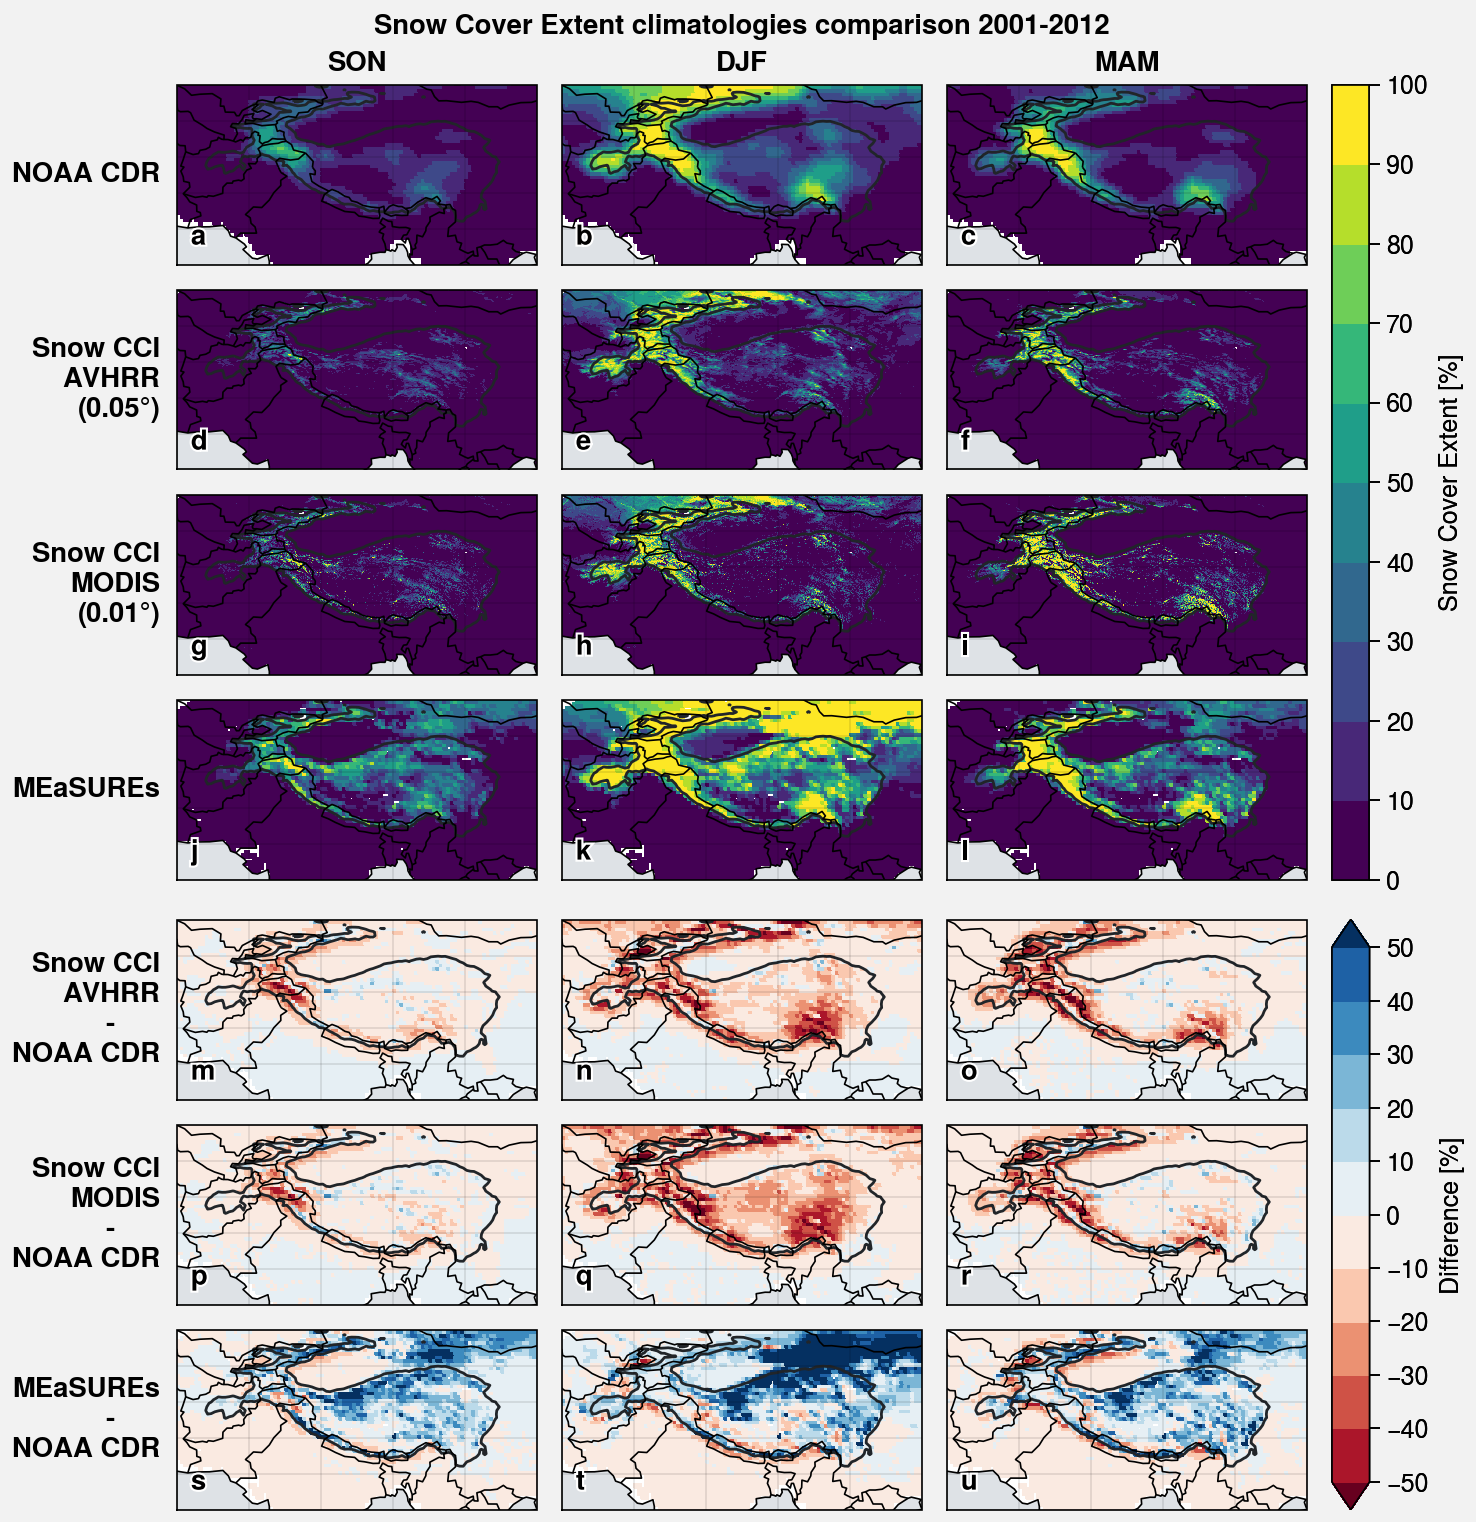

In [348]:
# seasons = ['SON', 'DJF', 'MAM', 'JJA']
# seasons = ['DJF', 'MAM', 'JJA']
seasons = ['SON', 'DJF', 'MAM']
var = 'snc'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)


# obs_list_names = ['CRU', 'CMFD', 'CRU - CMFD']
obs_list_names = ['NOAA CDR', 'Snow CCI\nAVHRR\n(0.05°)', 'Snow CCI\nMODIS\n(0.01°)', 'MEaSUREs',
                  'Snow CCI\nAVHRR\n-      \nNOAA CDR', 'Snow CCI\nMODIS\n-      \nNOAA CDR', 'MEaSUREs\n-      \nNOAA CDR']

fig, axs = plot.subplots(ncols=len(seasons), nrows=len(obs_list), proj='cyl', axwidth=1.8)

k = 0

for i, obs in enumerate(obs_list):
    for season in seasons:
        if i < 4:
            m1 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap, levels=levels, extend='neither')
        else:
            m2 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
            
        k += 1


# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='r', rows=(1,4))
fig.colorbar(m2, label='Difference ['+units+']', loc='r', rows=(5,7))

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle=label+' climatologies comparison '+period_2.start+'-'+period_2.stop
)

for ext in ['jpg']:
    fig.save('img/scf_comparison_seas_2001-2012.'+ext)

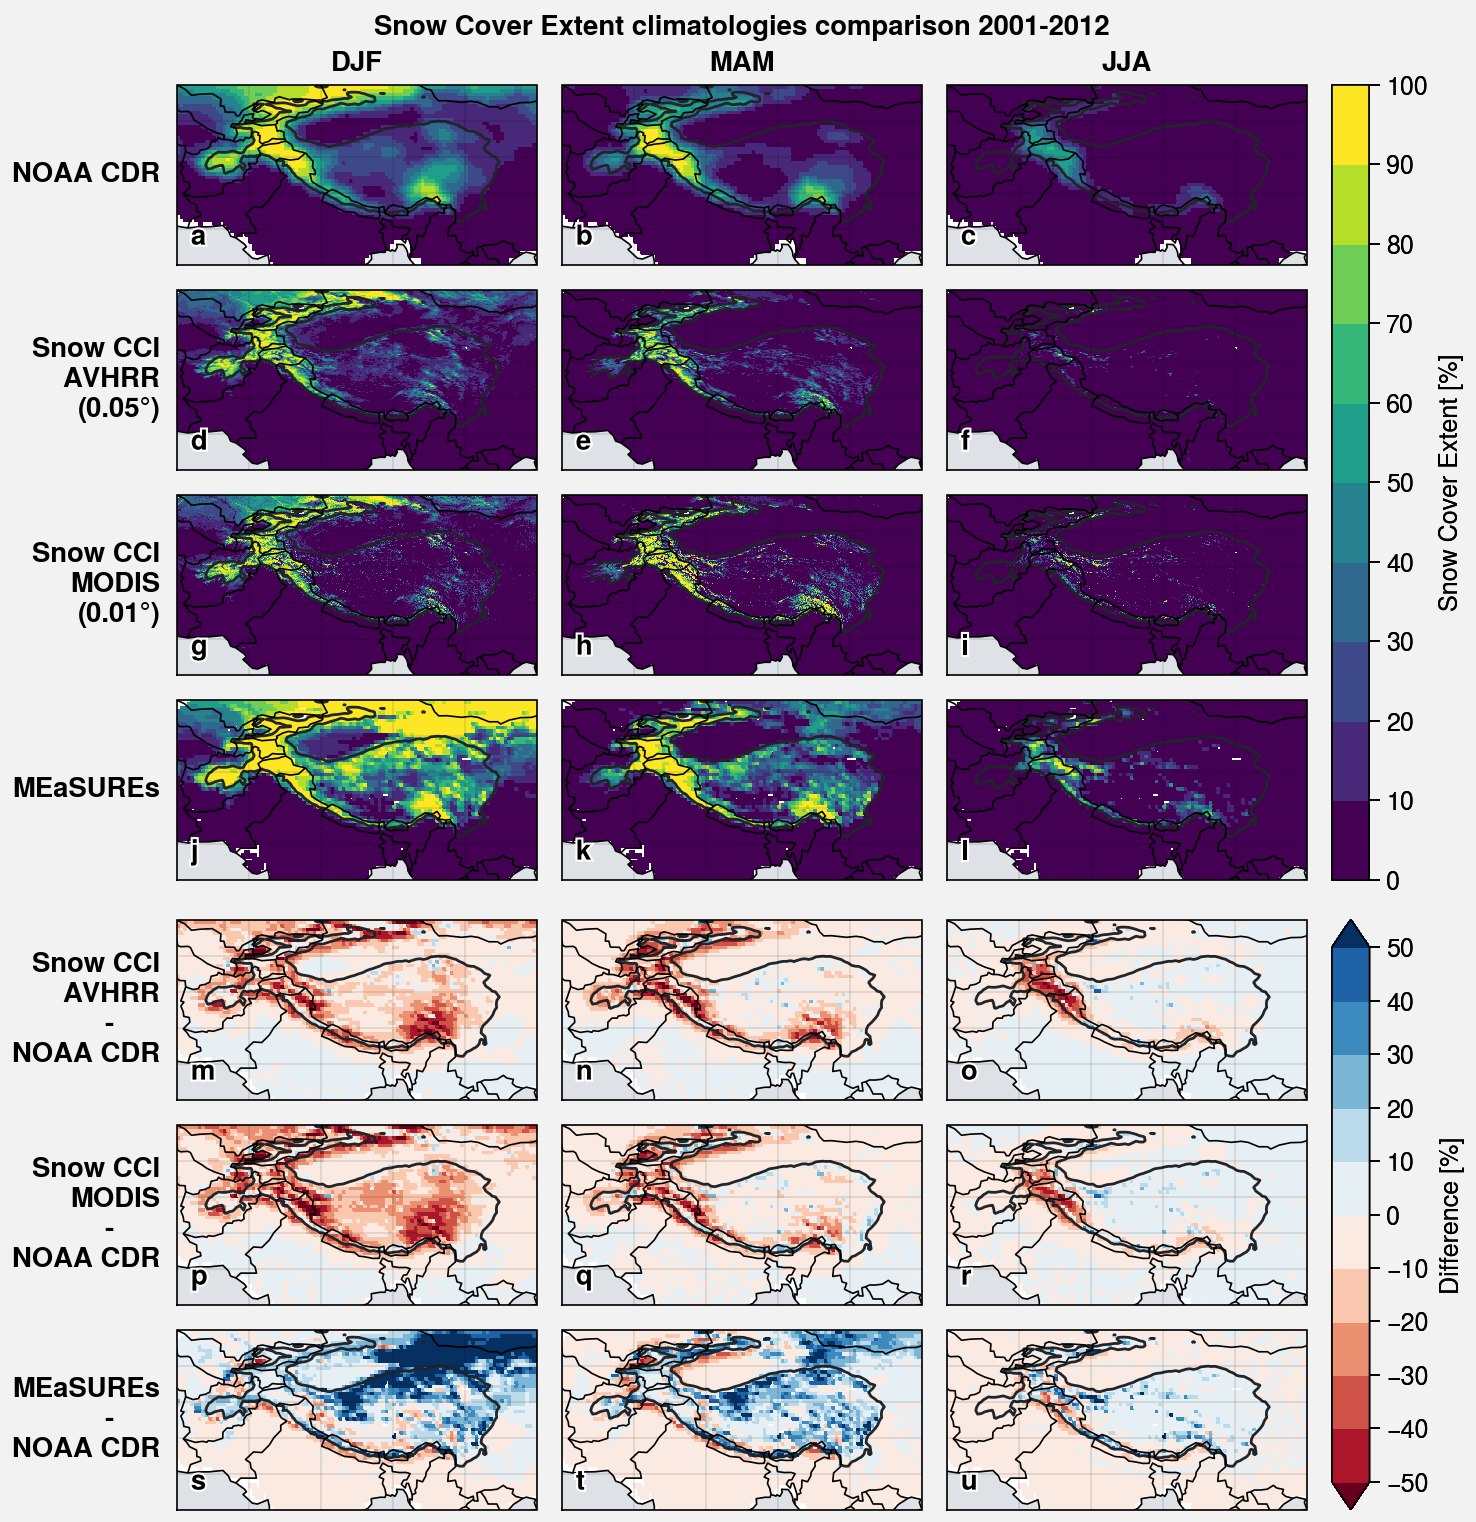

In [349]:
# seasons = ['SON', 'DJF', 'MAM', 'JJA']
seasons = ['DJF', 'MAM', 'JJA']
# seasons = ['SON', 'DJF', 'MAM']
var = 'snc'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)


# obs_list_names = ['CRU', 'CMFD', 'CRU - CMFD']
obs_list_names = ['NOAA CDR', 'Snow CCI\nAVHRR\n(0.05°)', 'Snow CCI\nMODIS\n(0.01°)', 'MEaSUREs',
                  'Snow CCI\nAVHRR\n-      \nNOAA CDR', 'Snow CCI\nMODIS\n-      \nNOAA CDR', 'MEaSUREs\n-      \nNOAA CDR']

fig, axs = plot.subplots(ncols=len(seasons), nrows=len(obs_list), proj='cyl', axwidth=1.8)

k = 0

for i, obs in enumerate(obs_list):
    for season in seasons:
        if i < 4:
            m1 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap, levels=levels, extend='neither')
        else:
            m2 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
            
        k += 1


# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='r', rows=(1,4))
fig.colorbar(m2, label='Difference ['+units+']', loc='r', rows=(5,7))

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle=label+' climatologies comparison '+period_2.start+'-'+period_2.stop
)

# Annexe

In [309]:
# noaa_cdr_seas = noaa_cdr.groupby('time.season').mean('time').load()

# snow_cci_interp_orig_seas = snow_cci_interp_orig.groupby('time.season').mean('time').load()
# snow_cci_interp_seas = snow_cci_interp.groupby('time.season').mean('time').load()

# snow_cci_MODIS_interp_orig_seas = snow_cci_MODIS_interp_orig.groupby('time.season').mean('time').load()
# snow_cci_MODIS_interp_seas = snow_cci_MODIS_interp.groupby('time.season').mean('time').load()

snow_cci_avhrr_3d_not_filled_old_seas = snow_cci_avhrr_3d_not_filled_old.groupby('time.season').mean('time').load()
snow_cci_avhrr_3d_coarsen_seas = snow_cci_avhrr_3d_coarsen.groupby('time.season').mean('time').load()

modis_seas = modis.groupby('time.season').mean('time').load()
modis_coarsen_seas = modis_coarsen.groupby('time.season').mean('time').load()

# measures_seas = measures.groupby('time.season').mean('time').load()

obs_list = [
    snow_cci_interp_orig_seas, snow_cci_avhrr_3d_not_filled_old_seas, snow_cci_avhrr_3d_coarsen_seas - snow_cci_interp_seas,
    snow_cci_MODIS_interp_orig_seas, modis_seas, modis_coarsen_seas - snow_cci_MODIS_interp_seas
]

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [330]:
obs_list = [
    snow_cci_interp_orig_seas, snow_cci_avhrr_3d_not_filled_old_seas, snow_cci_avhrr_3d_coarsen_seas - snow_cci_interp_seas,
    snow_cci_MODIS_interp_orig_seas, modis_seas, modis_coarsen_seas - snow_cci_MODIS_interp_seas
]

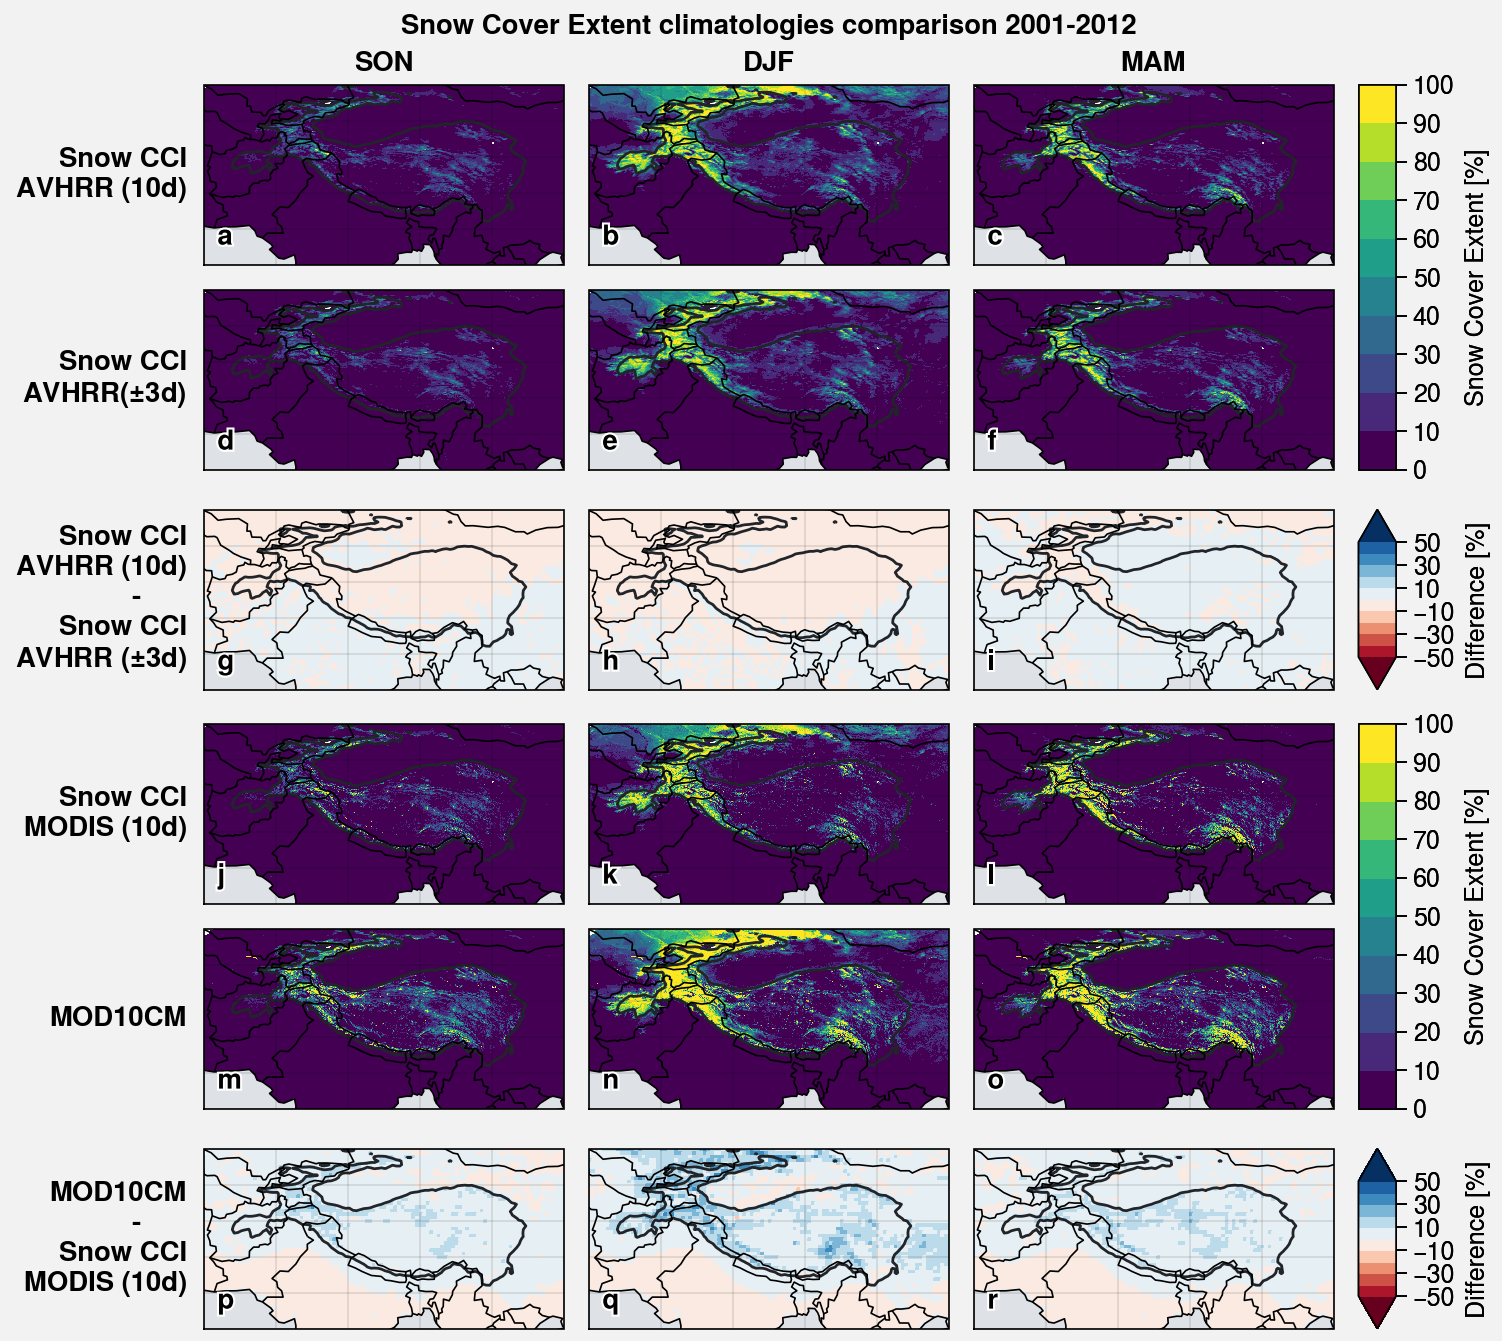

In [331]:
# seasons = ['SON', 'DJF', 'MAM', 'JJA']
# seasons = ['DJF', 'MAM', 'JJA']
seasons = ['SON', 'DJF', 'MAM']
var = 'snc'

label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)


# obs_list_names = ['CRU', 'CMFD', 'CRU - CMFD']
obs_list_names = ['Snow CCI\nAVHRR (10d)', 'Snow CCI\nAVHRR($\pm$3d)', 'Snow CCI\nAVHRR (10d)\n-      \nSnow CCI\nAVHRR ($\pm$3d)',
                  'Snow CCI\nMODIS (10d)', 'MOD10CM', 'MOD10CM\n-      \nSnow CCI\nMODIS (10d)']

fig, axs = plot.subplots(ncols=len(seasons), nrows=len(obs_list), proj='cyl', axwidth=1.8)

k = 0

for i, obs in enumerate(obs_list):
    for season in seasons:
        if i in [0, 1, 3, 4]:
            m1 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap, levels=levels, extend='neither')
        else:
            m2 = axs[k].pcolormesh(obs.sel(season=season), cmap=cmap_diff, levels=levels_diff, extend='both')
            
        k += 1


# fig.colorbar(m, label='Snow Cover Extent [%]') 
fig.colorbar(m1, label=label+' ['+units+']', loc='r', rows=(1,2))
fig.colorbar(m1, label=label+' ['+units+']', loc='r', rows=(4,5))
fig.colorbar(m2, label='Difference ['+units+']', loc='r', row=3)
fig.colorbar(m2, label='Difference ['+units+']', loc='r', row=6)

for ax in axs:
    ax.contour(elevation, levels=[2500], color='gray9', linewidth=1)

axs.format(
    # Grids, labels and limits
    labels=False, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    abc=True, abcloc='ll',
    rowlabels=obs_list_names, collabels=seasons,
    suptitle=label+' climatologies comparison '+period_2.start+'-'+period_2.stop
)

for ext in ['jpg']:
    fig.save('img/scf_interp_comparison_seas_2001-2012.'+ext)

## Time series

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


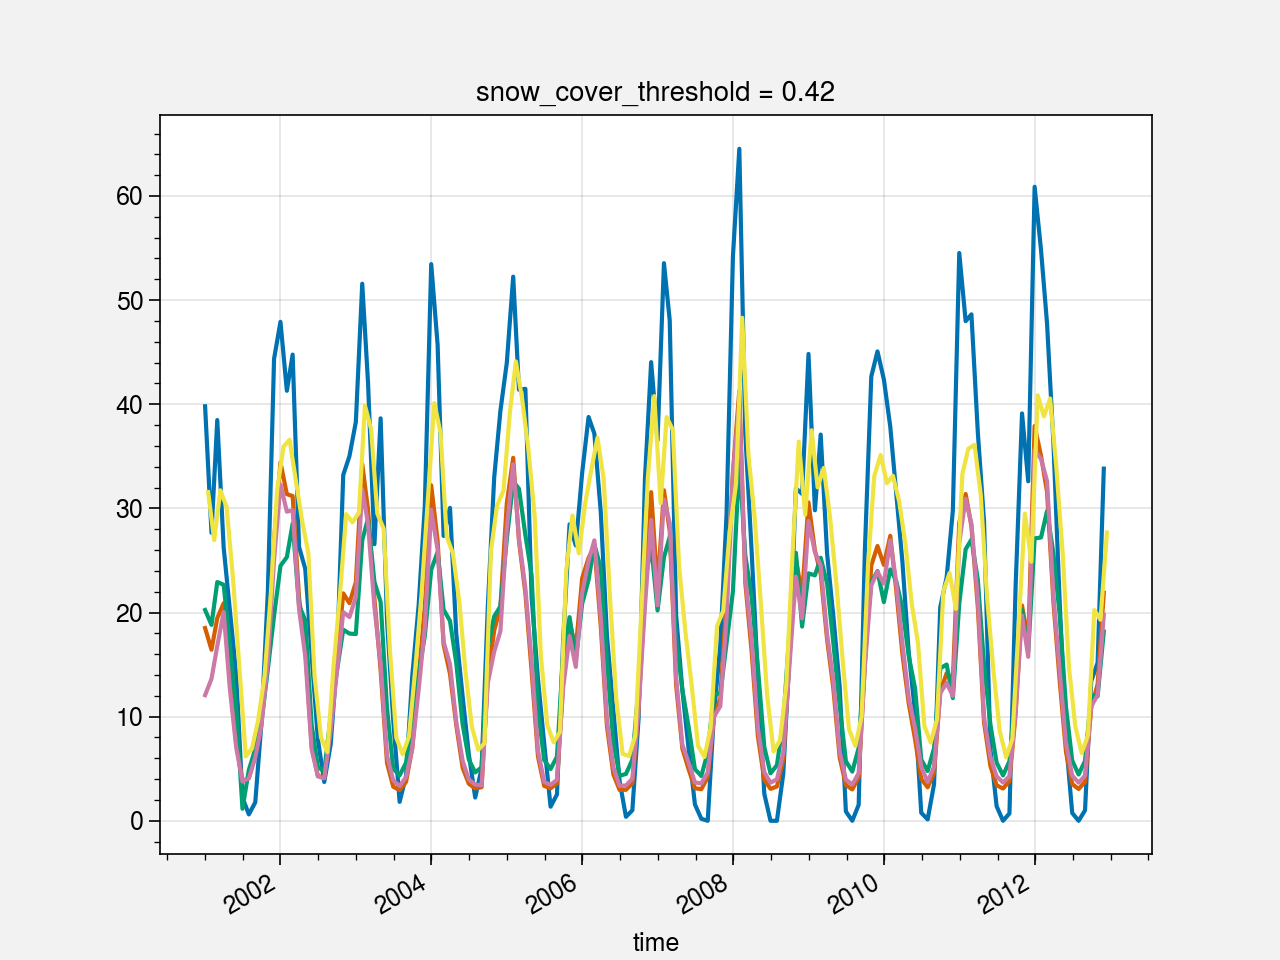

In [289]:
u.spatial_average(noaa_cdr_2.where(elevation > 2500)).plot()
u.spatial_average(snow_cci_interp.where(elevation > 2500)).plot()
u.spatial_average(snow_cci_MODIS_interp.where(elevation > 2500)).plot()
u.spatial_average(snow_cci_avhrr_3d_coarsen.where(elevation > 2500)).plot()
u.spatial_average(modis_coarsen.where(elevation > 2500)).plot()
# u.spatial_average(measures.where(elevation > 2500)).plot()

In [334]:
noaa_cdr_2_ts = u.spatial_average(noaa_cdr_2.where(elevation > 2500)).load()
snow_cci_interp_ts = u.spatial_average(snow_cci_interp.where(elevation > 2500)).load()
snow_cci_MODIS_interp_ts = u.spatial_average(snow_cci_MODIS_interp.where(elevation > 2500)).load()
snow_cci_avhrr_3d_coarsen_ts = u.spatial_average(snow_cci_avhrr_3d_coarsen.where(elevation > 2500)).load()
modis_coarsen_ts = u.spatial_average(modis_coarsen.where(elevation > 2500)).load()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


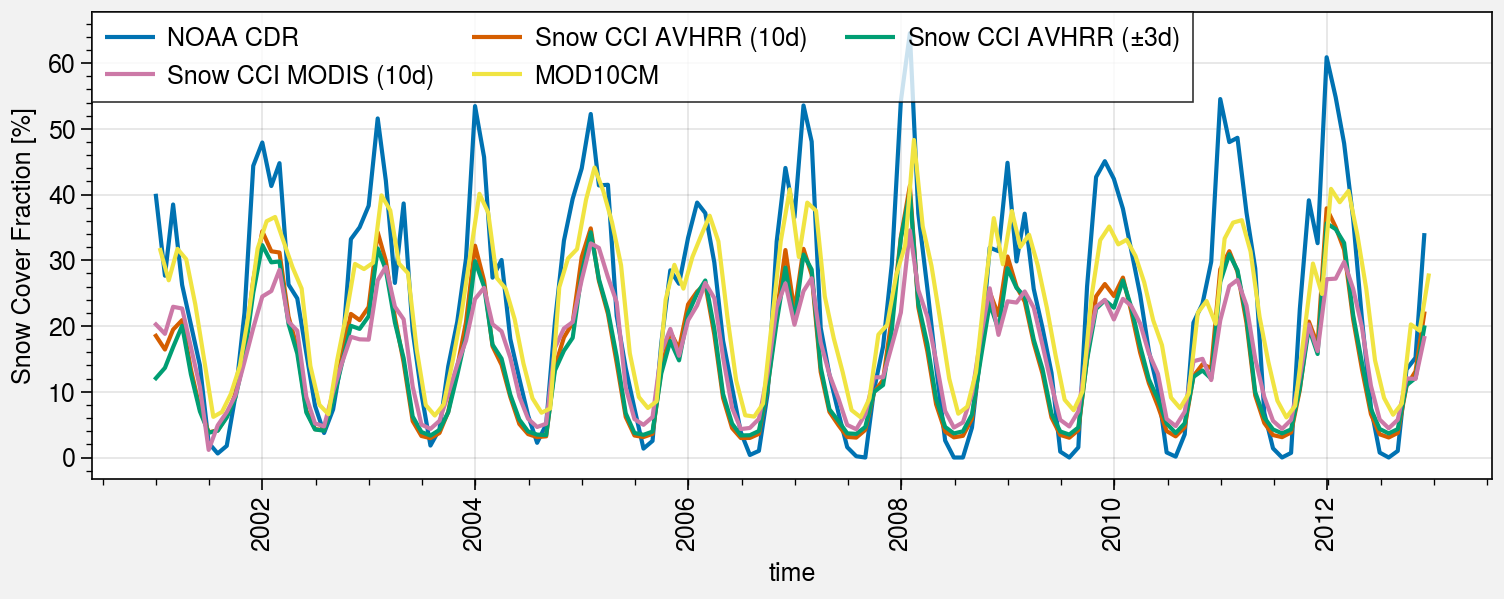

In [346]:
fig, axs = plot.subplots(aspect=3, axwidth=7)

axs[0].plot(noaa_cdr_2_ts, label='NOAA CDR')
axs[0].plot(snow_cci_interp_ts, label='Snow CCI AVHRR (10d)')
axs[0].plot(snow_cci_avhrr_3d_coarsen_ts, label='Snow CCI AVHRR ($\pm$3d)')
axs[0].plot(snow_cci_MODIS_interp_ts, label='Snow CCI MODIS (10d)')
axs[0].plot(modis_coarsen_ts, label='MOD10CM')

axs[0].legend()
axs[0].format(ylabel='Snow Cover Fraction [%]')

for ext in ['jpg', 'pdf']:
    fig.save('img/scf_interp_comparison_seas_ts_2001-2012.'+ext)

## Trends ?